# Lista 5
#### Michał Ilski 250079

#### Własna implementacja przechowywania macierzy

Macierz wejściowa **A** składa się w z bloków mniejszych macierzy typu $A$, $B$ i $C$ oraz zer. Znając układ takiej macierzy (rysunek niżej) można zaproponować wydajny sposób przechowywania jej w pamięci. W tym celu została zaimplementowana struktura *CustomMatrix*, zawierająca wartości *n, l, v* (kolejno rozmiar kwadratowej macierzy **A**, rozmiar bloku i $v=\frac{n}{l}$) oraz listy bloków $A$, $B$ i $C$.

![](1.png)

In [1]:
mutable struct CustomMatrix
    n::Int64
    l::Int64
    v::Int64
    A_blocks::Array{Array{Float64,2},1}
    B_blocks::Array{Array{Float64,2},1}
    C_blocks::Array{Array{Float64,2},1}
    function CustomMatrix(n::Int64, l::Int64)
        v = n/l
        A_blocks = [Array{Float64}(zeros(l,l)) for idx in 1:n]
        B_blocks = [Array{Float64}(zeros(l,l)) for idx in 1:n]
        C_blocks = [Array{Float64}(zeros(l,l)) for idx in 1:n]
        return new(n, l, v, A_blocks, B_blocks, C_blocks)
    end
end

Funkcja *set_value* służy do ustawiania wartości *value* w macierzy *c* dla komórki o indeksie *[i,j]*. Na podstawie rozmiaru bloku w macierzy *A* oraz indeksie rzędu *i*, możemy określi zakres kolumn, w których możemy dokonać zmiany wartości. Do tego wyznaczam pomocniczą wartość $k = \lfloor\frac{i-1}{l}\rfloor\cdot l$. Ta zmienna wyznacza pierwszą kolumnę, znajdującą się przed blokiem $A$ w rzędzie *i* (w szczególności może być równa $0$, czyli poza macierzą). Następnie sprawdzam, gdzie względem *k* znajduje się indeks $j$ i odpowiednio przechodzę do bloków $A$, $B$, $C$, lub zgłaszam błąd, gdybym wyszedł poza zakres tych bloków. Następnie na podstawie rzędu *i* wybieram odpowiedni blok z listy bloków i ustawiam w nim wartość. Indeksy względne w każdym bloku wyznaczam za pomocą operacji $(i-1)mod(l)+1$ oraz $(j-1)mod(l)+1$, ponieważ indeksowanie w języku Julia odbywa się od $1$ (a nie od $0$).

In [2]:
function set_value(c::CustomMatrix, i::Int64, j::Int64, value::Float64)
    l = c.l
    k = ((i-1)÷l)*l
    if j in k+1:k+l
        c.A_blocks[(i÷l)+1][((i-1)%l+1), ((j-1)%l+1)] = value
    elseif j in k-l+1:k
        c.B_blocks[(i÷l)+1][((i-1)%l+1), ((j-1)%l+1)] = value
    elseif j in k+l+1:k+2*l
        c.C_blocks[(i÷l)+1][((i-1)%l+1), ((j-1)%l+1)] = value
    else
         println("ERROR in ", i, " ", j)
    end
end

set_value (generic function with 1 method)

Funkcja *get_value* pobiera wartość z macierzy *c*, z komórki o indeksie *[i,j]*. Zasada dostawania się do komórki jest identyczna jak wyżej, z tą różnicą, że możemy zaglądać poza wyznaczone bloki $A$, $B$ i $C$ - wtedy dostajemy wartość $0$.

In [3]:
function get_value(c::CustomMatrix, i::Int64, j::Int64)
    l = c.l
    k = ((i-1)÷l)*l
    if j in k+1:k+l
        return c.A_blocks[(i÷l)+1][((i-1)%l+1), ((j-1)%l+1)]
    elseif j in k-l+1:k
        return c.B_blocks[(i÷l)+1][((i-1)%l+1), ((j-1)%l+1)]
    elseif j in k+l+1:k+2*l
        return c.C_blocks[(i÷l)+1][((i-1)%l+1), ((j-1)%l+1)]
    end
    return 0.0
end

get_value (generic function with 1 method)

#### Funkcja czytająca macierz z pliku  
Funkcja read_matrix na wejściu przyjmuje ścieżkę, w którym znajduje się plik z macierzą oraz nazwę pliku. W funkcji w pierwszej kolejności czytane są wartości $n$ (rozmiar macierzy) oraz $l$ (rozmiar bloków w macierzy głównej). Następnie każda kolejna linia to $i$ (pierwszy indeks macierzy), $j$ (drugi indeks macierzy), $A[i,j]$. Komórki macierzy, dla których nie zostały podane wartości w pliku przyjmują wartość $0$. Zwracana jest wczytana macierz, $n$ oraz $l$.

In [4]:
function read_matrix(folder::String,filename::String)
    path = "$folder/$filename"
    
    open(path, "r") do io
        n, l = (parse(Int64, x) for x in split(readline(io), " "))
        matrix = CustomMatrix(n,l)
        while !eof(io)
            line = split(readline(io), " ")
            i,j,value = (parse(Int64,line[1]), parse(Int64,line[2]), parse(Float64,line[3]))
            set_value(matrix, i, j ,value)
        end
        
        return matrix, n, l
    end    
end

read_matrix (generic function with 1 method)

#### Funkcja czytająca wektor z pliku
Wektor wczytywany jest podobnie jak wyżej. Tutaj jednak jedynymi danymi są długość wektora $n$ oraz jego $n$ wartości. Zwracany jest wektor wraz z wymiarem.

In [5]:
function read_vector(folder::String,filename::String)
    path = "$folder/$filename"
    
    open(path, "r") do io
        n = parse(Int64, readline(io))
        vector = Vector{Float64}(zeros(n))
        for i in 1:n
            vector[i] = parse(Float64, readline(io))
        end
        
        return vector, n
    end    
end

read_vector (generic function with 1 method)

#### Funkcja generująca wektor $b$
Znając macierz $A$ oraz wiedząc, że wektor $x = [1,...,1]^{T}$, możemy samodzielnie wyznaczyć postać wektora $b$. W tym celu wykonuję mnożenie $Ax = b$. W pętli iteruję po wszystkich rzędach, natomiast ze względu na specyficzną postać macierzy $A$, nie muszę iterować po wszystkich kolumnach. Będąc w $i$-tym rzędzie, sumuję wartości w zakresie od $max\{1,l\cdot\lceil\frac{i-l}{l}\rceil\}$ do $min\{n,l\cdot\lceil\frac{i-l}{l}\rceil+l\}$, co obejmuje wartości z bloków $A_x$ i $B_x$ oraz w przypadku, gdy $i+l \leq n$, do $b[i]$ dodaję jeszcze $A[i, i+l]$, czyli bloki $C_x$.

In [6]:
function generate_b_vector(A::CustomMatrix, n::Int64, l::Int64)
    b = Vector{Float64}(zeros(n))
    for i in 1:n
        b[i] = sum(get_value(A,i,Int64(j)) for j in max(1,l*ceil((i-l)/l)):min(n,l*ceil((i-l)/l)+l))
        if i+l <= n
            b[i] += get_value(A,i,i+l)
        end
    end
    return b,n
end

generate_b_vector (generic function with 1 method)

#### Eliminacja Gaussa
Poniższa funkcja wykonuje algorytm eliminacji Gaussa. Na wejściu przyjmowane są: macierz *A*, wektor *b*, rozmiar *n* (macierzy) oraz *l* (bloku). Pętla zewnętrzna iteruje po kolejnych rzędach, wykonująć n-1 iteracji (poza ostatnim rzędem). Wewnętrzna pętla wyznacza mnożnik $l_{i,k} = \frac{a_{i,k}}{a_{k,k}}$, po czym druga wewnętrzna pętla aktualizuje wartości w rzędzie według wzoru: $a_{i,j} = a_{i,j} - l_{i,k}a_{k,j}$. Podobnie wartość w wektorze *b* ulega zmianie: $b_i = b_i - l_{i,k}b_i$. Górnym limitem iteracji może być $min\{k+l, n\}$, ze względu na specyficzną postać macierzy *A* (nie ma sensu liczyć w blokach, gdzie mamy pewność, że są same $0$). Podany algorytm składa się z 3 zagnieżdżonych pętli, których liczbę wykonań można ograniczyć przez rozmiar *n* macierzy. Stąd złożoność takiego algorytmu to $O(n^3)$.

In [7]:
function gaussian_elimination(A::CustomMatrix, b::Vector{Float64}, n::Int64, l::Int64)
    for k in 1:(n-1)
        for i in (k+1):min(k+l, n)
            lik = get_value(A,i,k)/get_value(A,k,k)
            set_value(A,i,k,0.0)
            for j in k+1:min(k+l, n)
                temp = get_value(A,i,j)
                set_value(A,i,j,temp-lik*get_value(A,k,j))
            end
            b[i] -= lik*b[k]
        end
    end       
end

gaussian_elimination (generic function with 1 method)

#### Rozwiązanie równania po wykonaniu eliminacji Gaussa
Funkcja *solve_using_gaussian_elimination* rozwiązuje równanie $Ax=b$, wyznaczając wartość wektora *x*. Funkcja korzysta z postaci macierzy *A* i wektora *b* po przekształceniu z wykorzystaniem funkcji wyżej. W pierwszej kolejności został zainicjowany wektor *x* o rozmiarze *n* (rozmiar wynika bezpośrednio z własności mnożenia macierzy). Następnie pętla rozpoczyna iterację od dolnego rzędu, kierując się w górę macierzy. W pętli wewnętrznej liczona jest wartość danego rzędu macierzy, czyli $s = \sum_{k<j<=min\{n, k+l\}} a_{k,j}x_{j}$, analogicznie jak ma to miejsce podczas mnożenia macierzy razy wektor. Korzystając z wiedzy na temat *b*, wyznaczamy $x_k = \frac{b_{k}-s}{a_{k,k}}$. Limit wewnętrznej pętli można ograniczyć przez $min\{n,k+l\}$ ze względu na specyficzną postać macierzy. Ostatecznie algorytm zawiera dwie pętle (zagnieżdżone), których limit iteracji można ograniczyć z góry przez *n*. Stąd złożoność algorytmu to $O(n^2)$.

In [8]:
function solve_using_gaussian_elimination(A::CustomMatrix, b::Vector{Float64}, n::Int64, l::Int64)
    x = Vector{Float64}(zeros(n))
    for k in n:-1:1
        matrix_sum = 0
        for j = k + 1:min(n, k + l)
            matrix_sum += get_value(A,k,j)*x[j]
        end
        x[k] = (b[k] - matrix_sum)/get_value(A,k,k)
    end
    return x
end

solve_using_gaussian_elimination (generic function with 1 method)

#### Eliminacja Gaussa z wyborem elementu głównego

Poniższa funkcja przypomina zasadą działania podstawową wersję eliminacji Gaussa (tę wyżej). Różnica polega na samodzielnym wyborze elementu głównego w taki sposób, aby był on możliwie daleki od wartości 0, aby generować możliwie małe błędy, powstające podczas wykonywania działań. W tym celu został dodatkowo zainicjowany wektor *order*, który będzie zawierał informacje o indeksach rzędów w macierzy, po przekształceniu jej poprzez wybieranie elementu głównego. W zewnętrznej pętli dodatkowo został dopisany kod, który w liniowym czasie znajduje maksymalną wartość bezwględną w danej kolumnie (poniżej aktualnego rzędu) i zamienia aktualny rząd z macierzy z tym, który zawiera tę wartość. Stosując wektor *order*, będący permutacją indeksów rzędów, nie ma potrzeby przebudowywać macierzy w pamięci. Dalsza część kodu jest analogiczna do implementacji wyżej, przy czym zamiast elementu $a_{i,j}$ wybieramy $a_{order[i],j}$ (podobnie w *b*). W tej implementacji znajduje się dodatkowo pętla wyznacząjąca wartość maksymalną dla danego rzędu o złożoności $O(n)$, co daje wciąż złożoność całego algorytmu $O(n^3)$.

In [9]:
function gaussian_elimination_choose_element(A::CustomMatrix, b::Vector{Float64}, n::Int64, l::Int64)
    order = Vector(1:n)
    
    for k in 1:(n-1)
        current_max, max_id = abs(get_value(A,order[k],k)), k
        for i in (k+1):min(k+l, n)
            if abs(get_value(A,order[i],k)) > current_max
                current_max, max_id = abs(get_value(A,order[i],k)), i
            end
        end
        order[max_id], order[k] = order[k], order[max_id]
        
        for i in (k+1):min(k+l, n)
            lik = get_value(A,order[i],k)/get_value(A,order[k],k)
            set_value(A,order[i],k,0.0)
            for j in k+1:min(k+2*l-((k-1)%l+1), n)
                temp = get_value(A,order[i],j)
                set_value(A,order[i],j,temp-lik*get_value(A,order[k],j))     
            end
            b[order[i]] -= lik*b[order[k]]
        end
    end
    return order
end

gaussian_elimination_choose_element (generic function with 1 method)

#### Rozwiązanie równania po wykonaniu eliminacji Gaussa z wyborem elementu głównego

Rozwiązanie równania z wyborem elementu głównego jest analogiczne do tego, w którym nie wybieramy elementu. Różnica polega braniu wartości z macierzy *A* zgodnie z przekazanym na wejściu porządkiem (zwróconym w funkcji wyżej), tzn. zamiast $a_{i,j}$ bierzemy $a_{order[i],j}$. Na samym końcu chcemy zwrócić *x*, który zostałby wyliczony dla *A* i *b* bez modyfikacji wyboru elementu głównego. W tym celu deklaruję wektor *res* i podpisuję wartości z *x* tak, że ${res_i = x_{order[i]}}$ (w ostaniej pętli). Ostania pętla ma złożoność $O(n)$, co pozostawia złożoność algorytmu $O(n^2)$, jak wyżej.

In [10]:
function solve_using_gaussian_elimination_choose_element(A::CustomMatrix, b::Vector{Float64}, order::Vector{Int64}, n::Int64, l::Int64)
    x = Vector{Float64}(zeros(n))
    for k = n:-1:1
        matrix_sum = 0.0
        for j = k + 1:min(k+2*l, n)
            matrix_sum += get_value(A,order[k],j)*x[j]
        end

        x[k] = (b[order[k]] - matrix_sum)/get_value(A,order[k],k)
    end
    
    res = zeros(n)
    
    for i in 1:n
        res[i] = x[order[i]]
    end

    return x
end

solve_using_gaussian_elimination_choose_element (generic function with 1 method)

#### Rozkład LU

Korzystając z powyższej implementacji eliminacji Gaussa, został napisany rozkład LU dla macierzy *A*. W miejscu dotychczasowej macierzy *A*, będą znajdować się 2 macierze trójkątne L (dolna) oraz U (górna), takie, ze $A = LU$. 
W danej kolumnie *k* przechodzę po wartościach w rzędach niżej i ustawiam $a_{i,k}$ = $l_{i,k}$ (a nie $0$ jak wcześniej). Ponadto nie interesuje mnie tutaj wektor *b*, co jest korzystne, ponieważ jednorazowy rozkład *LU* będę mógł wykorzystać wiele razy. Podobnie jak wyżej, złożoność algorytmu to $O(n^3)$.

In [11]:
function lu(A::CustomMatrix, n::Int64, l::Int64)
    for k in 1:(n-1)
        for i in (k+1):min(k+l, n)
            lik = get_value(A,i,k)/get_value(A,k,k)
            set_value(A,i,k,lik)
            for j in k+1:min(k+l, n)
                temp = get_value(A,i,j)
                set_value(A,i,j,temp-lik*get_value(A,k,j))
            end
        end
    end       
end

lu (generic function with 1 method)

#### Rozwiąznie równania z użyciem rozkładu LU

Rozwiązania równania $Ax=b$, mając *A* w postaci *LU*, można rozbić na rozwiązanie dwóch równań - $Ly=b$ oraz $Ux=y$. Rozwiązywanie obu równań odbywa się analogicznie jak przy macierzy po eliminacji Gaussa. Najpierw rozpatrujemy macierz dolną, czyli iterujemy od górnego rzędu w dół. Zakres iteracji pętli wewnętrznej jest od $max\{1,\lfloor\frac{i-1}{l}\rfloor l\}$ do $i-1$ (czyli ograniczony przez diagonalę). Obliczony *y* przekazujemy niżej do rozwiązania drugiego równania dla macierzy górnej. Tutaj granice iteracji jak dla algorytmu eliminacji Gaussa. Rozwiązanie jednego takiego równania ma złożoność $O(n^2)$. Rozwiązujemy niezależnie 2 takie równania, więc złożoność algorytmu wynosi $O(n^2)$.

In [12]:
function solve_lu(A::CustomMatrix, b::Vector{Float64}, n::Int64, l::Int64)
    
    y = Vector{Float64}(zeros(n))
    for i in 1:n
        matrix_sum = 0.0
        #TODO zmienić
        for j in max(1, Int64(l*floor((i-1)/l))):i-1
            matrix_sum += get_value(A,i,j)*y[j]
        end
        y[i] = b[i] - matrix_sum
    end
    
    x = Vector{Float64}(zeros(n))
    
    for k = n:-1:1
        matrix_sum = 0.0
        for j = k+1:min(n, k+l)
            matrix_sum += get_value(A,k,j)*x[j]
        end
        x[k] = (y[k] - matrix_sum)/get_value(A,k,k)
    end

    return x
end
    
        

solve_lu (generic function with 1 method)

#### Rozkład LU z wyborem elementu głównego

Poniższa funkcja działa analogicznie do powyższej implementacji rozkładu *LU*. Wybór elementu głównego wprowadza konieczność znalezienia wartości w kolumnie możliwie dalekiej od $0$ oraz uwzględnianie nowego porządku elementów podczas sięgania po nie do macierzy (podobnie jak w eliminacji Gaussa z wyborem elementu głównego). Ponownie, wybór elementu głównego nie wpływa na rząd złożoności obliczeniowej danej funkcji, czyli jest równy $O(n^3)$.

In [13]:
function lu_choose_element(A::CustomMatrix, n::Int64, l::Int64)
    order = Vector(1:n)
    
    for k in 1:(n-1)
        current_max, max_id = abs(get_value(A,order[k],k)), k
        for i in (k+1):min(k+l, n)
            if abs(get_value(A,order[i],k)) > current_max
                current_max, max_id = abs(get_value(A,order[i],k)), i
            end
        end
        order[max_id], order[k] = order[k], order[max_id]
        
        for i in (k+1):min(k+l, n)
            lik = get_value(A,order[i],k)/get_value(A,order[k],k)
            set_value(A,order[i],k,lik)
            for j in k+1:min(k+2*l-((k-1)%l + 1), n)
                temp = get_value(A,order[i],j)
                set_value(A,order[i],j,temp-lik*get_value(A,order[k],j))     
            end
        end
    end
    return order
end

lu_choose_element (generic function with 1 method)

#### Rozwiązanie równania z rozkładem LU i wyborem elementu głównego
Funkcja działa analogicznie jak bez wyboru elementu głównego. Jedyna różnica polega na uwzględnieniu nowego porządku podczas sięgania po komórki w macierzy. Złożoność to $O(n^2)$.

In [14]:
function solve_lu_choose_element(A::CustomMatrix, b::Vector{Float64}, order::Vector{Int64}, n::Int64, l::Int64)
    y = Vector{Float64}(zeros(n))
    for i in 1:n
        matrix_sum = 0.0
        for j in max(1, i-2*l):i-1
            matrix_sum += get_value(A,order[i],j)*y[j]
        end
        y[i] = b[order[i]] - matrix_sum
    end
    
    x = Vector{Float64}(zeros(n))
    
    for k = n:-1:1
        matrix_sum = 0.0
        for j = k+1:min(n, k+2*l)
            matrix_sum += get_value(A,order[k],j)*x[j]
        end
        x[k] = (y[k] - matrix_sum)/get_value(A,order[k],k)
    end

    return x
end

solve_lu_choose_element (generic function with 1 method)

#### Wypisywanie rozwiązania
Zgodnie z trecią zadania, poniższa funkcja wypisuje błąd względny oraz wektor wynikowy *x*. W przypadku pustej ścieżki wynik zostanie wypisany na standardowe wyjście.

In [15]:
function write_x(x::Vector{Float64}, n::Int64, generated_b::Bool, path::String)
    if path != ""
        open(path, "w") do file
            if generated_b 
                error = norm(ones(n)-x)/norm(x)
                println(file, error)
            end
            for i = 1:n
                println(file, x[i])
            end
        end
    else
        if generated_b 
            error = norm(ones(n)-x)/norm(x)
            println(error)
        end
        for i = 1:n
            println(x[i])
        end
    end
end

write_x (generic function with 1 method)

### Testy poprawności działania 

In [16]:
using LinearAlgebra #dla funkcji norm

##### n = 16, b wczytywany, eliminacja gaussa

In [17]:
A,n,l = read_matrix("Dane16_1_1/", "A.txt")
b, n = read_vector("Dane16_1_1/", "b.txt")
gaussian_elimination(A,b,n,l)
x = solve_using_gaussian_elimination(A,b,n,l)
write_x(x, n, false, "")

1.0000000000000007
1.0000000000000007
1.0000000000000007
1.0000000000000013
0.9999999999999997
0.9999999999999996
0.9999999999999996
0.9999999999999994
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002


##### n = 16, b generowany, eliminacja gaussa z wyborem elementu

In [18]:
A,n,l = read_matrix("Dane16_1_1/", "A.txt")
b, n = generate_b_vector(A,n,l)
order = gaussian_elimination_choose_element(A,b,n,l)
x = solve_using_gaussian_elimination_choose_element(A,b,order,n,l)
write_x(x, n, true, "")

2.8844440295753465e-16
0.9999999999999997
0.9999999999999999
0.9999999999999998
1.0
0.9999999999999997
0.9999999999999996
0.9999999999999996
0.9999999999999993
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999997
0.9999999999999998


##### n = 16, b generowany, rozkład LU

In [19]:
A,n,l = read_matrix("Dane16_1_1/", "A.txt")
b, n = generate_b_vector(A,n,l)
lu(A,n,l)
x = solve_lu(A,b,n,l)
write_x(x, n, true, "")

9.879581447690234e-16
1.0
0.9999999999999998
1.0000000000000004
1.0000000000000007
0.9999999999999994
0.9999999999999998
0.9999999999999996
0.9999999999999993
1.0000000000000036
1.0000000000000004
1.0000000000000004
1.0000000000000007
0.9999999999999998
0.9999999999999997
0.9999999999999997
0.9999999999999996


##### n = 16, b generowany, rozkład LU z wyborem elementu głównego

In [20]:
A,n,l = read_matrix("Dane16_1_1/", "A.txt")
b, n = generate_b_vector(A,n,l)
order = lu_choose_element(A,n,l)
x = solve_lu_choose_element(A,b,order,n,l)
write_x(x, n, true, "")

2.64771316376407e-16
0.9999999999999997
0.9999999999999999
0.9999999999999998
1.0
0.9999999999999997
0.9999999999999997
0.9999999999999996
0.9999999999999996
1.0000000000000002
1.0
1.0
1.0
0.9999999999999999
0.9999999999999998
0.9999999999999997
0.9999999999999997


W powyższych testach wszystkie algorytmy dały wyniki zgodne z oczekiwaniami (wektor samych jedynek), a otrzymane błędy względne były niewielkie - największy jest tutaj rzędu $10^{-16}$.

##### n = 50000, b generowany
Ze względu na duży rozmiar macierzy dla $n = 50000$, wypiszę jedynie błędy względne dla każdej z metod:

In [21]:
function write_x_error(x::Vector{Float64}, n::Int64)
    error = norm(ones(n)-x)/norm(x)
    println(error)
end

write_x_error (generic function with 1 method)

##### eliminacja Gaussa

In [22]:
A,n,l = read_matrix("Dane50000_1_1/", "A.txt")
b, n = generate_b_vector(A,n,l)
gaussian_elimination(A,b,n,l)
x = solve_using_gaussian_elimination(A,b,n,l)
write_x_error(x, n)

1.8398915733251618e-13


##### eliminacja Gaussa z wyborem elementu głównego

In [23]:
A,n,l = read_matrix("Dane50000_1_1/", "A.txt")
b, n = generate_b_vector(A,n,l)
order = gaussian_elimination_choose_element(A,b,n,l)
x = solve_using_gaussian_elimination_choose_element(A,b,order,n,l)
write_x_error(x, n)

3.9285991202114373e-16


##### rozkład LU

In [24]:
A,n,l = read_matrix("Dane50000_1_1/", "A.txt")
b, n = generate_b_vector(A,n,l)
lu(A,n,l)
x = solve_lu(A,b,n,l)
write_x_error(x, n)

2.0040929265984656e-13


##### rozkład LU z wyborem elementu głównego

In [25]:
A,n,l = read_matrix("Dane50000_1_1/", "A.txt")
b, n = generate_b_vector(A,n,l)
order = lu_choose_element(A,n,l)
x = solve_lu_choose_element(A,b,order,n,l)
write_x_error(x, n)

3.886151700163112e-16


W przypadku większych macierzy pojawiają się już różnice w rzędach wielkości błędów względnych rozwiązań. Jak widać, metody z wyborem elementu głównego dają mniejsze błędy (rzędu $10^{-16}$), niż te bez ($10^{-13}$).

### Testy wydajności algorytmów 

In [26]:
include("./matrixgen.jl") 

Main.matrixgen

In [27]:
using PyPlot
using .matrixgen

Poniższy fragment kodu generuje przy pomocy funckji *blockmat* macierze rozmiarów $n \in \{1000,5000,10000,15000,...,50000\}$ o blokach rozmiaru $10$, do pliku *temp_matrix.txt*, po czym dla każdej z nich wczytuje macierz do przygotowanej wcześniej stuktury (własna implementacja *CustomMatrix*), generuje wektor $b$, wykonuje każdy z 4 algorytmów i zapisuje czas wykonania oraz zużycie pamięci dla poszególnych przypadków.

In [28]:
sizes = [i for i in 1000:5000:50000]
block = 10
folder = "."
file_name = "temp_matrix.mat"
gauss_time = []
gauss_mem = []
gauss_choose_time = []
gauss_choose_mem = []
lu_time = []
lu_mem = []
lu_choose_time = []
lu_choose_mem = []

for size in sizes
    blockmat(size, block, 1.0, file_name)
    
    #gauss
    A1,n,l = read_matrix(folder,file_name)
    b,n = generate_b_vector(A1,n,l)
    
    data1 = @timed gaussian_elimination(A1,b,n,l)
    data2 = @timed solve_using_gaussian_elimination(A1,b,n,l)
    push!(gauss_time, data1[2]+data2[2])
    push!(gauss_mem, data1[3]+data2[3])
    
    GC.gc()
    
    #gauss with choose
    A2,n,l = read_matrix(folder,file_name)
    b,n = generate_b_vector(A2,n,l)
    
    data1 = @timed gaussian_elimination_choose_element(A2,b,n,l)
    data2 = @timed solve_using_gaussian_elimination_choose_element(A2,b,data1[1],n,l)
    push!(gauss_choose_time, data1[2]+data2[2])
    push!(gauss_choose_mem, data1[3]+data2[3])
    
    GC.gc()
    
    #lu
    A3,n,l = read_matrix(folder,file_name)
    b,n = generate_b_vector(A3,n,l)
    
    data1 = @timed lu(A3,n,l)
    data2 = @timed solve_lu(A3,b,n,l)
    push!(lu_time, data1[2]+data2[2])
    push!(lu_mem, data1[3]+data2[3])
    
    GC.gc()
    
    #lu with choose
    A4,n,l = read_matrix(folder,file_name)
    b,n = generate_b_vector(A4,n,l)
    
    data1 = @timed lu_choose_element(A4,n,l)
    data2 = @timed solve_using_gaussian_elimination_choose_element(A4,b,data1[1],n,l)
    push!(lu_choose_time, data1[2]+data2[2])
    push!(lu_choose_mem, data1[3]+data2[3])
end

#### Wykresy przedstawiające czas rozwiązania układu $Ax=b$ metodą eliminacji Gaussa

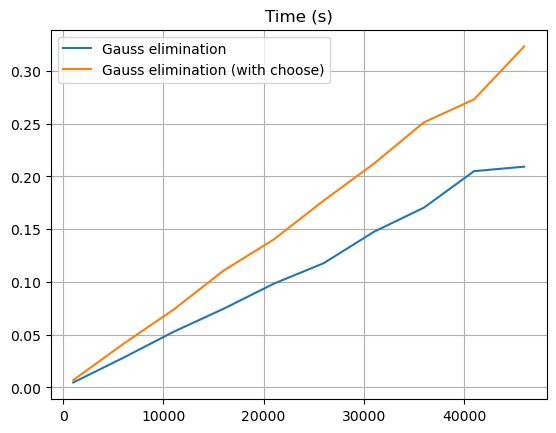

In [29]:
title("Time (s)")
plot(sizes, gauss_time, label="Gauss elimination")
plot(sizes, gauss_choose_time, label="Gauss elimination (with choose)")
legend()
grid()

#### Wykresy przedstawiające czas rozwiązania układu $Ax=b$ przy użyciu rozkładu LU

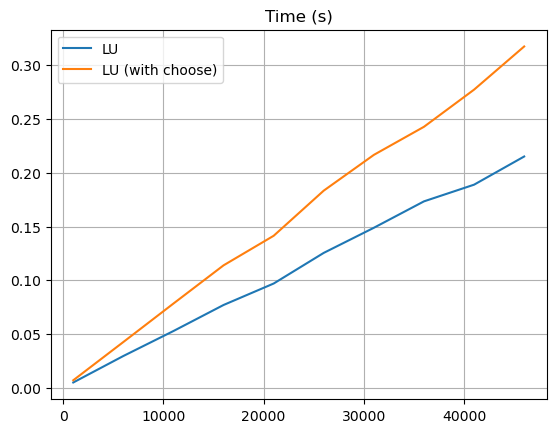

In [30]:
title("Time (s)")
plot(sizes, lu_time, label="LU")
plot(sizes, lu_choose_time, label="LU (with choose)")
legend()
grid()

#### Zestawienie obu metod z wyborem i bez wyboru elementu głównego

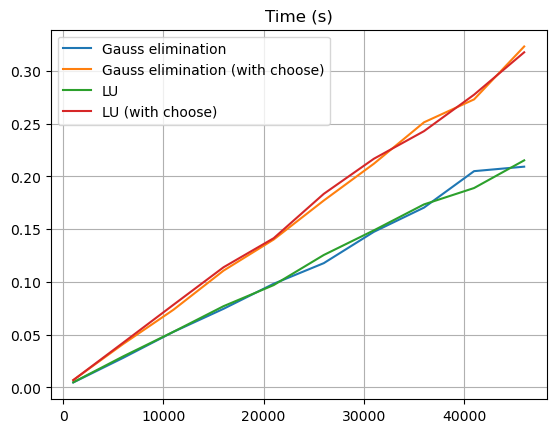

In [31]:
title("Time (s)")
plot(sizes, gauss_time, label="Gauss elimination")
plot(sizes, gauss_choose_time, label="Gauss elimination (with choose)")
plot(sizes, lu_time, label="LU")
plot(sizes, lu_choose_time, label="LU (with choose)")
legend()
grid()

#### Wykresy przedstawiające zużycie pamięci dla rozwiązania układu $Ax=b$ metodą eliminacji Gaussa

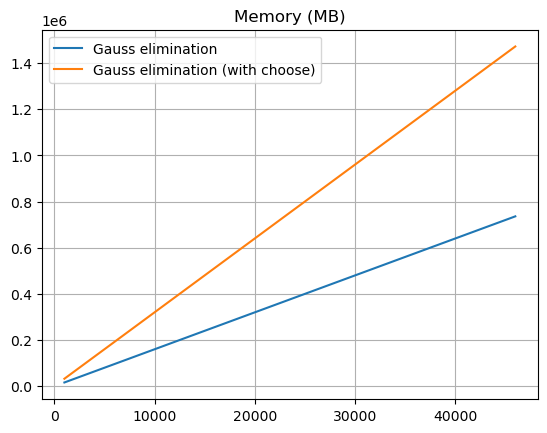

In [32]:
title("Memory (MB)")
plot(sizes, gauss_mem, label="Gauss elimination")
plot(sizes, gauss_choose_mem, label="Gauss elimination (with choose)")
legend()
grid()

#### Wykresy przedstawiające zużycie pamięci dla rozwiązania układu $Ax=b$ z użyciem rozkładu LU

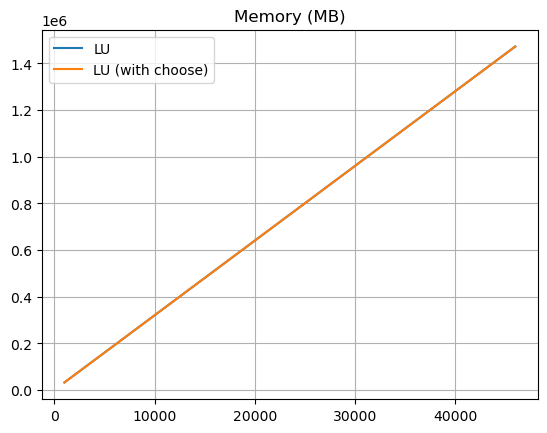

In [33]:
title("Memory (MB)")
plot(sizes, lu_mem, label="LU")
plot(sizes, lu_choose_mem, label="LU (with choose)")
legend()
grid()

#### Zestawienie obu metod z wyborem i bez wyboru elementu głównego

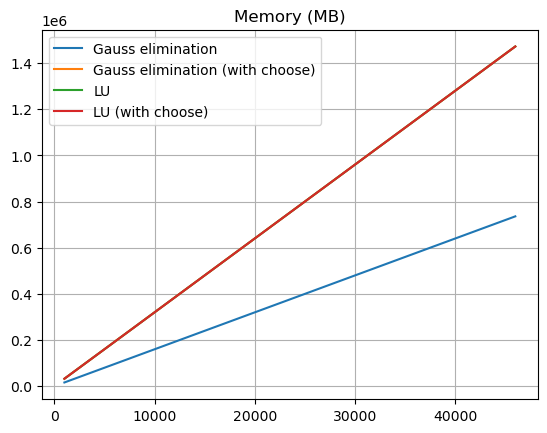

In [34]:
title("Memory (MB)")
plot(sizes, gauss_mem, label="Gauss elimination")
plot(sizes, gauss_choose_mem, label="Gauss elimination (with choose)")
plot(sizes, lu_mem, label="LU")
plot(sizes, lu_choose_mem, label="LU (with choose)")
legend()
grid()

#### Wnioski

Na podstawie przeprowadzonych testów, widać że zaimplementowane 4 metody rozwiązywania układów równań działają poprawnie. Zastosowanie częściowego wyboru elementu głównego miało za zadanie zmieniejszyć błąd względny, powstający podczas wykonywania obliczeń na macierzach. W testach dla $n = 50000$ można zauważyć, że różnica jest faktycznie istotna (3 rzędy wielkości). Takie rozwiązanie odbywa się jednak kosztem dodatkowej pracy, polegającej na wyborze elementu głównego. Rezultaty tego widać na wykresach czasu wykonań algorytmów, gdzie algorytmy wzbogacone o wybór elementu trwają istotnie dłużej niż ich wersje podstawowe. Podobnie wygląda sytuacja ze zużyciem pamięci, przez wektor pomocniczy *order*. Nie ma znaczących różnic zarówno w jakości wyników, czasie realizacji i zużyciu pamięci pomiędzy klasycznym rozwiązaniem układu metodą Gaussa a rozkładem LU (eliminacja Gaussa jest zwykle nieco szybsza). W przypadku jednak, gdy musimy rozwiązywać wiele takich układów dla niezmiennej macierzy *A* i wielu wektórów *b*, lepszy okazuje się jednorazowy rozkład LU (ponieważ jest on niezależny od *b*), niż użycie klasycznej eliminacji Gaussa (zależnej od *b*).